In [1]:
import numpy as np
import pandas as pd

stockPrices = pd.read_csv("data_challenge_stock_prices.csv")
indexPrices = pd.read_csv("data_challenge_index_prices.csv")

In [2]:
for data in [stockPrices, indexPrices]:
    # Display general information about the data
    print("Data shape:", data.shape)
    # Display information about missing values
    print("Number of missing values: ", data.isnull().sum().sum(), "\n")

Data shape: (200000, 100)
Number of missing values:  0 

Data shape: (200000, 15)
Number of missing values:  0 



There is no missing data. All data is in float64. There are 200000 timestamps.

In [3]:
stockReturns = (stockPrices.iloc[:, :]*10000 - stockPrices.iloc[:, :].shift(1)*10000) / stockPrices.iloc[:, :].shift(1)
stockReturns = stockReturns.drop(index=0)
indexReturns = (indexPrices.iloc[:, :]*10000 - indexPrices.iloc[:, :].shift(1)*10000) / indexPrices.iloc[:, :].shift(1)
indexReturns = indexReturns.drop(index=0)

In [4]:
# Compute correlation matrix of returns
corr_matrix = stockReturns.corr()

# **Finding M using elbow method**

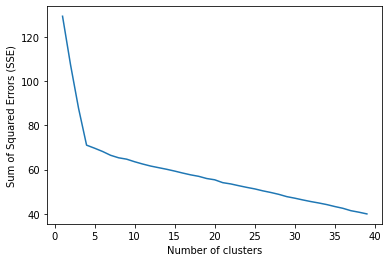

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering for different values of K and compute SSE
sse = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(corr_matrix.values)
    sse.append(kmeans.inertia_)

# Plot the SSE curve
plt.plot(range(1, 40), sse)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

Elbow can be seen at **M = 4**

**Confimation using silhouette score**

In [6]:
from sklearn.metrics import silhouette_score
# Compute silhouette scores for different values of K
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(corr_matrix.values)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(corr_matrix.values, labels))

# Find the optimal number of clusters with the highest silhouette score
optimal_k = np.argmax(silhouette_scores) + 2
print("Optimal number of clusters:", optimal_k)
if(optimal_k == 4):
    print("There are 4 clusters")
else:
    print("Optimal cluster number mismatch")

Optimal number of clusters: 4
There are 4 clusters


Optimal number of clusters: 4, there are 4 clusters.

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42).fit(corr_matrix.values)

stock_to_sector = [0]*100
sector_to_stocks = {}
sector_labels = {}
for i, label in enumerate(kmeans.labels_):
    stock_to_sector[i] = label
    if label in sector_labels:
        sector_labels[label].append(stockReturns.columns[i])
    else:
        sector_labels[label] = [stockReturns.columns[i]]

for i in range(kmeans.n_clusters):
    cluster_stocks = stockReturns.columns[kmeans.labels_ == i]
    print(f"Cluster {i}: {', '.join(cluster_stocks)}")

Cluster 0: 2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91, 98
Cluster 1: 8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96, 99
Cluster 2: 0, 1, 4, 10, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 88, 90
Cluster 3: 5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95, 97


Cluster 0: 2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91, 98
Cluster 1: 8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96, 99
Cluster 2: 0, 1, 4, 10, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 88, 90
Cluster 3: 5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95, 97

Clusters look good with an almost uniform distribution. For K = 5 clusters, one of the clusters had just one element, which was odd, these 4 clusters look optimal.

# **Match indices with sectors**

In [8]:
# Find the sector for each index using correlation between mean returns of sectors with index
index_sectors = {}
for index_name in indexReturns.columns:
    index_returns = indexReturns[index_name].values
    sector_correlations = []
    for sector_label in range(4):
        sector_returns = stockReturns.iloc[:, kmeans.labels_ == sector_label].mean(axis=1).values
        sector_correlation = np.corrcoef(index_returns, sector_returns)[0, 1]
        sector_correlations.append((sector_label, abs(sector_correlation)))
    max_correlation = max(sector_correlations, key=lambda x: x[1])
    index_sectors[index_name] = (max_correlation[0], max_correlation[1])
    print("Index:", index_name, "Sector:", max_correlation[0], "Corr:", max_correlation[1])

Index: 0 Sector: 2 Corr: 0.445580334425943
Index: 1 Sector: 3 Corr: 0.3058405843770878
Index: 2 Sector: 2 Corr: 0.13484760547292896
Index: 3 Sector: 0 Corr: 0.16303989139437203
Index: 4 Sector: 1 Corr: 0.4482812694059309
Index: 5 Sector: 3 Corr: 0.15596710247479492
Index: 6 Sector: 0 Corr: 0.44475654482666227
Index: 7 Sector: 2 Corr: 0.30041678316825027
Index: 8 Sector: 0 Corr: 0.3030765132972553
Index: 9 Sector: 1 Corr: 0.16774036731401093
Index: 10 Sector: 3 Corr: 0.15758145721398722
Index: 11 Sector: 3 Corr: 0.0029650878687741272
Index: 12 Sector: 0 Corr: 0.0034282719129466715
Index: 13 Sector: 0 Corr: 0.005307889478163166
Index: 14 Sector: 1 Corr: 0.14348645142692934


We found sectors of each index using its absolute correlation with average return of each sector.

Index: 0 Sector: 2 Corr: 0.445580334425943
Index: 1 Sector: 3 Corr: 0.3058405843770878
Index: 2 Sector: 2 Corr: 0.13484760547292896
Index: 3 Sector: 0 Corr: 0.16303989139437203
Index: 4 Sector: 1 Corr: 0.4482812694059309
Index: 5 Sector: 3 Corr: 0.15596710247479492
Index: 6 Sector: 0 Corr: 0.44475654482666227
Index: 7 Sector: 2 Corr: 0.30041678316825027
Index: 8 Sector: 0 Corr: 0.3030765132972553
Index: 9 Sector: 1 Corr: 0.16774036731401093
Index: 10 Sector: 3 Corr: 0.15758145721398722
Index: 11 Sector: 3 Corr: 0.0029650878687741272
Index: 12 Sector: 0 Corr: 0.0034282719129466715
Index: 13 Sector: 0 Corr: 0.005307889478163166
Index: 14 Sector: 1 Corr: 0.14348645142692934

# **Linear Regression**

The most obvious index function is a linear combination of stock returns.

In [9]:
from sklearn.linear_model import LinearRegression
# Build models to predict index returns based on stock returns for each index and sector
for index_name in indexReturns.columns:
    sector_label = index_sectors[index_name][0]
    sector_stocks = sector_labels[sector_label]
    sector_returns = stockReturns[sector_stocks]
    index_returns = indexReturns[index_name].values.reshape(-1, 1)
    sector_returns_array = sector_returns.values.reshape(-1, len(sector_stocks))
    linear_model = LinearRegression().fit(sector_returns_array, index_returns)
    index_predicted = linear_model.predict(sector_returns_array)
    index_correlation = np.corrcoef(index_predicted.T, index_returns.T)[0, 1]
    print(f"Index {index_name}: Sector {sector_label}, Correlation {index_correlation}")

Index 0: Sector 2, Correlation 0.44567442907851257
Index 1: Sector 3, Correlation 0.3140056457544002
Index 2: Sector 2, Correlation 0.21222720544265816
Index 3: Sector 0, Correlation 0.3450763831413389
Index 4: Sector 1, Correlation 0.4483677169223754
Index 5: Sector 3, Correlation 0.22091893210657246
Index 6: Sector 0, Correlation 0.44495845572392784
Index 7: Sector 2, Correlation 0.30549805489771387
Index 8: Sector 0, Correlation 0.3075959839100972
Index 9: Sector 1, Correlation 0.34778816307930277
Index 10: Sector 3, Correlation 0.3433255783588396
Index 11: Sector 3, Correlation 0.010931740496889091
Index 12: Sector 0, Correlation 0.010568919492714851
Index 13: Sector 0, Correlation 0.012707198833396157
Index 14: Sector 1, Correlation 0.21456250655582648


This works well for indices 0, 4, 6 with correlation more than 0.4. Many corr values are close to 0.3, which made us believe we are on the right track. Next we will try to introduce polynomial regerssion of degree 2. Why? So, squaring the returns(r_i * r_i) is same as giving each return a weight w_i = r_i, then w_i * r_i = r_i * r_i. Meaning? This means that stocks with higher returns get a higher weight in the index.

**Polynomial Regression of Degree 2**

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

predictions_df = pd.DataFrame()

# Build models to predict index returns based on stock returns for each index and sector
for index_name in indexReturns.columns:
    sector_label = index_sectors[index_name][0]
    sector_stocks = sector_labels[sector_label]
    sector_returns = stockReturns[sector_stocks]
    index_returns = indexReturns[index_name].values.reshape(-1, 1)
    sector_returns_array = sector_returns.values.reshape(-1, len(sector_stocks))
    # Add polynomial features to stock returns
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(sector_returns_array)
    # Train polynomial regression model
    lin_regressor = LinearRegression()
    lin_regressor.fit(X_poly, index_returns)
    # X_train, X_test, y_train, y_test = train_test_split(X_poly, index_returns, test_size=0.4, random_state=42)

    # Predict index returns on training data
    index_predicted = lin_regressor.predict(X_poly)
    index_correlation = np.corrcoef(index_predicted.T, index_returns.T)[0, 1]
    if(index_correlation > 0.39):
        index_predicted.reshape(-1)
        index_predicted = np.squeeze(index_predicted)
        predictions_df.insert(len(predictions_df.columns), index_name, index_predicted)
    print(f"Index {index_name}: Sector {sector_label}, Correlation {index_correlation}")
print("Indices with ~0.4 correlation:", list(predictions_df.columns))

Index 0: Sector 2, Correlation 0.447146095055022
Index 1: Sector 3, Correlation 0.38020984233657706
Index 2: Sector 2, Correlation 0.46120134740658214
Index 3: Sector 0, Correlation 0.42923957746840535
Index 4: Sector 1, Correlation 0.449867830426194
Index 5: Sector 3, Correlation 0.4619025964471611
Index 6: Sector 0, Correlation 0.44640173121084403
Index 7: Sector 2, Correlation 0.3730464560609205
Index 8: Sector 0, Correlation 0.3721330020115219
Index 9: Sector 1, Correlation 0.4295930231082653
Index 10: Sector 3, Correlation 0.42907950046542276
Index 11: Sector 3, Correlation 0.04439114910148229
Index 12: Sector 0, Correlation 0.043633057748158656
Index 13: Sector 0, Correlation 0.4025002608539021
Index 14: Sector 1, Correlation 0.46090286435772265
Indices with ~0.4 correlation: ['0', '2', '3', '4', '5', '6', '9', '10', '13', '14']


This idea works well, we notice that we have figured out 10 indices (['0', '2', '3', '4', '5', '6', '9', '10', '13', '14']) here with a corr >= 0.4. Next we also add the cubic feature. Why? Well, when we square the term, large negative returns become a positive feature which is not good enough for fitting the curve. We also did a train-test split of 60-40, and observed that the correlations are very stable (changes in second decimal) improving our confidence on the model.

**Polynomial Regression of Degree 3**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

predictions_df = pd.DataFrame()

# Build models to predict index returns based on stock returns for each index and sector
for index_name in indexReturns.columns:
    sector_label = index_sectors[index_name][0]
    sector_stocks = sector_labels[sector_label]
    sector_returns = stockReturns[sector_stocks]
    index_returns = indexReturns[index_name].values.reshape(-1, 1)
    sector_returns_array = sector_returns.values.reshape(-1, len(sector_stocks))
    # Add polynomial features to stock returns
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(sector_returns_array)
    # Train polynomial regression model
    lin_regressor = LinearRegression()
    lin_regressor.fit(X_poly, index_returns)
    # Predict index returns on training data
    index_predicted = lin_regressor.predict(X_poly)
    index_correlation = np.corrcoef(index_predicted.T, index_returns.T)[0, 1]
    if(index_correlation > 0.39):
        print(index_predicted.shape)
        predictions_df.insert(len(predictions_df.columns), index_name, index_predicted)
    print(f"Index {index_name}: Sector {sector_label}, Correlation {index_correlation}")

print("Indices with ~0.4 correlation:", predictions_df.columns)

Index 0: Sector 2, Correlation 0.45967075296176
Index 1: Sector 3, Correlation 0.4342160054547381
Index 2: Sector 2, Correlation 0.5284253944792064
Index 3: Sector 0, Correlation 0.44328387966283966
Index 4: Sector 1, Correlation 0.46233310853546905
Index 5: Sector 3, Correlation 0.5216776614718718
Index 6: Sector 0, Correlation 0.460235787505698
Index 7: Sector 2, Correlation 0.4316195314420933
Index 8: Sector 0, Correlation 0.42965892971263564
Index 9: Sector 1, Correlation 0.44354749508825014
Index 10: Sector 3, Correlation 0.44317831338352254
Index 11: Sector 3, Correlation 0.1267403911558812
Index 12: Sector 0, Correlation 0.13080508429252258
Index 13: Sector 0, Correlation 0.41798726933407854
Index 14: Sector 1, Correlation 0.523913564483635

We see indices with >=0.4 correlation are ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '13', '14'].

We believe indices 11 and 12 are 'funny' indices. They don't seem to follow any pattern in our results and have very low correlations with stocks returns. All other indices have a correlation >0.4! 

**Find Covariance Matrix of k = 13 indices**

In [11]:
# Compute correlation matrix of returns
cov_matrix = predictions_df.cov()

# **Trading Strategy**

Optimizer: Maximize expected returns of allocation with a upper cap R on total risk.

In [58]:
from scipy import optimize
risks = []
def MaximizeReturnsConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    global risks
    def f(x, MeanReturns):
        func = -np.matmul(x, MeanReturns)
        return func
    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=0
        EqconstraintVal = np.matmul(AEq,x.T)-bEq
        return EqconstraintVal
    def constraintIneq(x, CovarReturns, R):
        AIneq = np.matmul(x, CovarReturns)
        bIneq = R
        global risks
        risks.append(np.matmul(AIneq, x.T))
        IneqconstraintVal = np.matmul(AIneq, x.T) - bIneq
        return IneqconstraintVal
    def zero_hessian(x, MeanReturns):
        n = len(x)
        return np.zeros((n, n))

    xinit = np.ones(PortfolioSize) / PortfolioSize
    mask = np.arange(PortfolioSize) % 2 == 1
    xinit[mask] *= -1

    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(CovarReturns, R)})
    lb = -1
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize(f, args = (MeanReturns), method ='trust-constr', x0 = xinit, bounds = bnds, constraints = cons, tol = 1e-3, hess = zero_hessian, options={'disp': False})
    return opt.x

We set (max-risk) R = 13, by using quantiles of the risks array above. The 50-75-90 quantiles are all around 13. The average is also around 13. So, we cap the max risk taken at 13.

In [ ]:
N = 200000 - 1
Sigma = np.array(cov_matrix)
portfolio_values = [0]
positions = np.zeros(len(predictions_df.columns))
profits = []

for t in range(N - 10000, N + 1):
    prices = indexPrices.iloc[t - 1, [int(x) for x in predictions_df.columns]]
    mu = predictions_df.iloc[t, :]
    wt = MaximizeReturnsConstr(mu, Sigma, len(mu), 13)
    positions += wt
    profits.append(np.dot(prices, positions).item() - portfolio_values[-1])
    portfolio_values.append(portfolio_values[-1] + np.dot(prices, wt).item())
    if(t%1000 == 0):
        print(t)

print("Final position value:", np.dot(prices, positions).item())
print("Final portfolio value:", portfolio_values[-1])

In [ ]:
print(np.quantile(risks, [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]))

OUTPUT:
Average of risk was ~ 13.41
QUNATILE FRACTIONS: [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1]
QUANTILE VALUES: [0.13700211 , 0.13700211 , 13.03479844 , 13.04290896 , 13.09123639 , 13.11938181 , 13.27213858 , 46.22563279 , 46.2256333]

We initially tested the code on first 10k datapoints. I have attached the portfolio profile below. The optimization was slow so we couldn't run on the complete dataset for testing. The strategy was profitable and consistent, the mean pnl was stable.

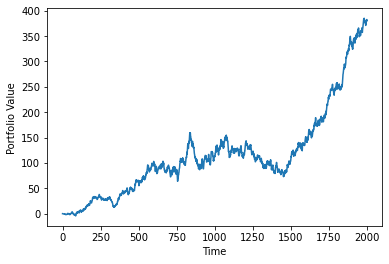

In [40]:
# Plot the portfolio value curve
plt.plot(range(0, N + 1), portfolio_values)
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.show()

In [ ]:
### Decision Tree Regressors give very high correlations on training, around 0.9. However, we believe they are overfitting over the train data ###

# from sklearn.ensemble import RandomForestRegressor

# index_predictions = {}
# index_actuals = {}
# # Build models to predict index returns based on stock returns for each index and sector
# for index_name in indexReturns.columns:
#     sector_label = index_sectors[index_name][0]
#     sector_stocks = sector_labels[sector_label]
#     sector_returns = stockReturns[sector_stocks]
#     index_returns = indexReturns[index_name]
#     sector_returns_array = sector_returns.values.reshape(-1, len(sector_stocks))
#     # Train Random Forest regressor
#     rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf_regressor.fit(sector_returns_array, index_returns.ravel())
#     # Predict index returns on training data
#     index_predicted = rf_regressor.predict(sector_returns_array)
#     index_predictions[index_name] = index_predicted
#     index_actuals[index_name] = index_predicted
#     index_correlation = np.corrcoef(index_predicted.T, index_returns.T)[0, 1]
#     print(f"Index {index_name}: Sector {sector_label}, Correlation {index_correlation}")